\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

# Question One {-}

In [1]:
import pandas as pd

bonds = pd.read_csv('bonds.txt', sep='\t', index_col=0)
# bonds = bonds[bonds['CouponRate'] > 6]
n = len(bonds)

bonds.head()

,CouponRate,BidPrice
Case,,
1,7.000,92.94
2,9.000,101.44
3,7.000,92.66
4,4.125,94.50
5,13.125,118.94


In [2]:
n

35

## 1. {-}

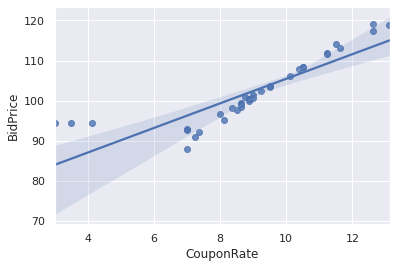

In [3]:
import seaborn as sns

sns.set_theme(color_codes=True)
ax = sns.regplot(x='CouponRate', y='BidPrice', data=bonds)

## 2. {-}

In [4]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

olsBonds = sm.OLS.from_formula(formula='BidPrice ~ CouponRate', data=bonds).fit()
olsBonds.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               BidPrice   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     99.87
Date:                Thu, 15 Oct 2020   Prob (F-statistic):           1.64e-11
Time:                        06:14:02   Log-Likelihood:                -98.656
No. Observations:                  35   AIC:                             201.3
Df Residuals:                      33   BIC:                             204.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.7866      2.827     26.458      0.000      69.036      80.537
CouponRate     3.0661      0.307      9.994      0.000       2.442       3.690
==============================================================================
Omnibus:                        3.313   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                2.262
Skew:                           0.607   Prob(JB):                        0.323
Kurtosis:                       3.276   Cond. No.                         37.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. {-}

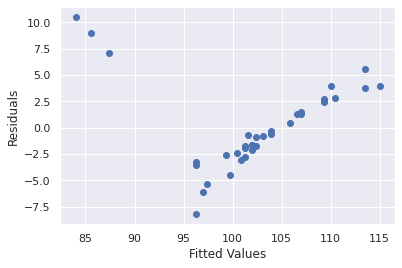

In [5]:
plt.scatter(olsBonds.fittedvalues, olsBonds.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

$$
\hat\beta_1 \pm z_{0.025}\text{SE}(\hat \beta_1)
$$
where the standard error is 
$$
\text{SE}(\hat\beta_1)\approx\frac{\hat\sigma}{s_x\sqrt{n-1}}
$$

$$
\hat\sigma^2 = \text{RSS}/(n-2)
$$

In [6]:
import numpy as np
from scipy.stats import norm, t

se = np.sqrt(olsBonds.ssr/(n-2))/(np.std(bonds['CouponRate'], ddof=1)*np.sqrt(n-1))
# z = t.ppf(1 - 0.025, n-2)
z = norm.ppf(1 - 0.025)

(olsBonds.params['CouponRate'] - (z*se), olsBonds.params['CouponRate'] + (z*se))

(2.464778252846198, 3.6674260585957033)

Assumption not correct (fitted-value plot), CI not meaningful



# Question Two {-}

## 1. {-}

In [7]:
data = pd.read_csv('bonddata.txt', sep=',')
data.head()

,id,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,...,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,10,1,126.268,7.616851,5.950,25.940349,0,12.540,150000.0,3,...,2862729,128.596,120000.0,2,127.561201,3621492,129.089,200000.0,2,129.435587
1,38,2,101.009,0.018373,3.550,0.326392,0,9.327,450000.0,3,...,532644,101.086,500000.0,2,101.103180,538510,101.070,25000.0,2,101.102243
2,336,3,108.144,3.537380,4.200,2.340601,0,0.102,160000.0,4,...,96293,107.917,400000.0,2,107.874965,96293,107.917,400000.0,4,107.874965
3,781,4,116.953,0.402523,4.875,7.367653,0,52.093,10000.0,4,...,92559,115.924,10000.0,2,116.160420,97177,116.458,2000.0,3,116.342802
4,1172,14,133.210,0.210685,10.750,4.159301,0,13.722,25000.0,4,...,6400208,127.500,25000.0,2,131.066998,6400208,127.500,25000.0,4,131.066998


In [8]:
data['bond_id'].unique().shape == data['bond_id'].shape

True

In [9]:
data.drop(['bond_id', 'id'], axis='columns', inplace=True)

In [10]:
import pandas as pd

catCols = ['is_callable'] + [colName for colName in data.columns if 'type' in colName]


### won't make a difference as get_dummies will automatically categorize the input columns
# for colName in catCols: 
#     data[colName] = data[colName].astype('category')


data = pd.get_dummies(data=data, columns=catCols)

In [11]:
import statsmodels.api as sm

X = sm.add_constant(data.drop('trade_price', axis='columns'))

fullmod = sm.OLS(endog=data['trade_price'], exog=X).fit()

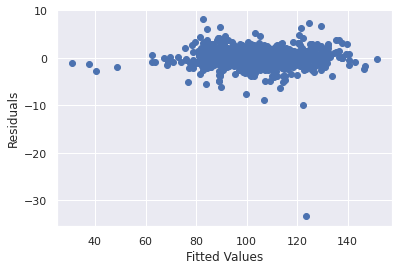

In [12]:
plt.scatter(fullmod.fittedvalues, fullmod.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

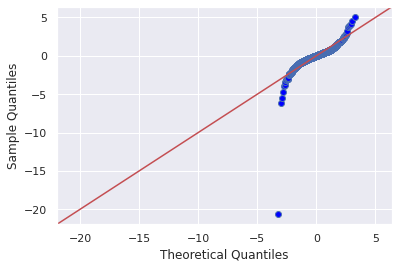

In [13]:
from statsmodels.graphics.gofplots import qqplot

qqplot(fullmod.resid, dist=norm, line='45', fit=True)
plt.show()

In [14]:
X

,const,weight,current_coupon,time_to_maturity,reporting_delay,trade_size,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,...,trade_type_last7_4,trade_type_last8_2,trade_type_last8_3,trade_type_last8_4,trade_type_last9_2,trade_type_last9_3,trade_type_last9_4,trade_type_last10_2,trade_type_last10_3,trade_type_last10_4
0,1.0,7.616851,5.95000,25.940349,12.540,150000.0,126.017363,343747,125.101,400000.0,...,0,0,0,1,1,0,0,1,0,0
1,1.0,0.018373,3.55000,0.326392,9.327,450000.0,101.068546,1,101.009,450000.0,...,0,1,0,0,1,0,0,1,0,0
2,1.0,3.537380,4.20000,2.340601,0.102,160000.0,107.927659,74139,107.990,6000.0,...,0,1,0,0,1,0,0,0,0,1
3,1.0,0.402523,4.87500,7.367653,52.093,10000.0,116.552464,959,115.842,5000.0,...,1,1,0,0,1,0,0,0,1,0
4,1.0,0.210685,10.75000,4.159301,13.722,25000.0,130.202417,262,133.612,25000.0,...,1,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,1.0,0.018373,5.95000,25.469243,0.638,5000.0,117.747938,1,116.407,5000.0,...,0,0,1,0,0,0,1,0,1,0
1616,1.0,3.151100,9.25000,3.034136,16.014,575000.0,101.400020,58831,101.520,273000.0,...,0,0,0,1,1,0,0,1,0,0
1617,1.0,8.477502,0.72625,2.527172,26.003,682000.0,94.987898,425818,92.000,29000.0,...,0,1,0,0,1,0,0,0,0,1
1618,1.0,3.830211,6.25000,5.444478,68.501,5000000.0,105.900870,86922,105.419,5000000.0,...,0,1,0,0,0,0,1,0,1,0


In [15]:
X.drop(['const'], axis='columns', inplace=True)

In [ ]:
chosen = []
remaining = list(X.columns.values)
p = len(X.columns)
bestAic = np.inf

for i in range(p):
    idx_aics = [(idx, sm.OLS(endog=data['trade_price'], exog=sm.add_constant(X[[feature] + chosen])).fit().aic) for idx, feature in enumerate(remaining)]
    idx, aic = min(idx_aics, key=lambda idx_aic: idx_aic[1])
    if aic >= bestAic:
        break
    bestAic = aic
    chosen.append(remaining[idx])
    remaining = remaining[:idx] + remaining[idx+1:]

chosen
